In [1]:
%pip install numpy matplotlib mne scikit-learn tensorflow seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GroupKFold, KFold
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D,  BatchNormalization, Activation, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
import numpy as np

In [3]:

# gauche / droite / poings / Pieds
def load_full_dataset(data_dir='/kaggle/input/physionet/files', n_subjects=109, classes=4):
    exclude_subjects = [88, 92, 100, 104]
    subjects = [s for s in range(1, n_subjects + 1) if s not in exclude_subjects]
    
    X_list, y_list, groups_list = [], [], []
    runs_lr = [4, 8, 12]
    runs_ff = [6, 10, 14]

    for subject_id in subjects:
        try:
            sub_data, sub_labels = [], []
            # --- 1. GAUCHE / DROITE ---
            raws_lr = []
            for run_id in runs_lr:
                subject_str, run_str = f"S{subject_id:03d}", f"R{run_id:02d}"
                file_path = os.path.join(data_dir, subject_str, f"{subject_str}{run_str}.edf")
                if os.path.exists(file_path):
                    raws_lr.append(mne.io.read_raw_edf(file_path, preload=True, verbose=False))
            
            if len(raws_lr) == 3:
                raw_lr = mne.concatenate_raws(raws_lr)
                mne.datasets.eegbci.standardize(raw_lr)
                events_lr, event_id_lr = mne.events_from_annotations(raw_lr, verbose=False)
                t1_val, t2_val = event_id_lr.get('T1'), event_id_lr.get('T2')
                events_lr = np.array([e for e in events_lr if e[2] in [t1_val, t2_val]])
                epochs_lr = mne.Epochs(raw_lr, events_lr, tmin=0, tmax=3.0, baseline=None, preload=True, verbose=False)
                
               
                sub_data.append(epochs_lr.get_data()[:, :, :480]) 
                sub_labels.append(np.array([0 if e == t1_val else 1 for e in epochs_lr.events[:, -1]]))

            # --- 2. POINGS / PIEDS ---
            if classes == 4:
                raws_ff = []
                for run_id in runs_ff:
                    subject_str, run_str = f"S{subject_id:03d}", f"R{run_id:02d}"
                    file_path = os.path.join(data_dir, subject_str, f"{subject_str}{run_str}.edf")
                    if os.path.exists(file_path):
                        raws_ff.append(mne.io.read_raw_edf(file_path, preload=True, verbose=False))
                
                if len(raws_ff) == 3:
                    raw_ff = mne.concatenate_raws(raws_ff)
                    mne.datasets.eegbci.standardize(raw_ff)
                    events_ff, event_id_ff = mne.events_from_annotations(raw_ff, verbose=False)
                    t1_f, t2_f = event_id_ff.get('T1'), event_id_ff.get('T2')
                    events_ff = np.array([e for e in events_ff if e[2] in [t1_f, t2_f]])
                    epochs_ff = mne.Epochs(raw_ff, events_ff, tmin=0, tmax=3.0, baseline=None, preload=True, verbose=False)
                    
               
                    sub_data.append(epochs_ff.get_data()[:, :, :480])
                    sub_labels.append(np.array([2 if e == t1_f else 3 for e in epochs_ff.events[:, -1]]))

            if sub_data:
                X_sub = np.concatenate(sub_data)
                y_sub = np.concatenate(sub_labels)
                scaler = StandardScaler()
                N, C, T = X_sub.shape
                X_sub = scaler.fit_transform(X_sub.transpose(0, 2, 1).reshape(-1, C)).reshape(N, T, C).transpose(0, 2, 1)
                X_list.append(X_sub)
                y_list.append(y_sub)
                groups_list.append(np.full(len(y_sub), subject_id))
        except: continue

    X = np.concatenate(X_list)[..., np.newaxis] )
    return X, to_categorical(np.concatenate(y_list), num_classes=classes), np.concatenate(groups_list)

In [3]:
import os
import mne
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

def load_full_dataset(data_dir='/kaggle/input/physionet/files', n_subjects=109, classes=4):
    exclude_subjects = [88, 92, 100, 104]
    subjects = [s for s in range(1, n_subjects + 1) if s not in exclude_subjects]
    
    X_list, y_list, groups_list = [], [], []
    runs_lr = [4, 8, 12]   # Gauche/Droite
    runs_ff = [6, 10, 14]  # Pieds (Run 6, 10, 14)

    for subject_id in subjects:
        try:
            sub_data, sub_labels = [], []
            subject_str = f"S{subject_id:03d}"
            
            # --- 1. CLASSE REPOS ---
            # Mapping: Rest=0
            if classes == 4:
                file_rest = os.path.join(data_dir, subject_str, f"{subject_str}R01.edf")
                if os.path.exists(file_rest):
                    raw_rest = mne.io.read_raw_edf(file_rest, preload=True, verbose=False)
                    epochs_rest = mne.make_fixed_length_epochs(raw_rest, duration=3.0, preload=True, verbose=False)
                    data_rest = epochs_rest.get_data(verbose=False)[:, :, :480]
                    sub_data.append(data_rest)
                    sub_labels.append(np.zeros(len(data_rest))) # Label 0

            # --- 2. GAUCHE / DROITE (POUR 2 ET 4 CLASSES) ---
            raws_lr = []
            for run_id in runs_lr:
                run_str = f"R{run_id:02d}"
                file_path = os.path.join(data_dir, subject_str, f"{subject_str}{run_str}.edf")
                if os.path.exists(file_path):
                    raws_lr.append(mne.io.read_raw_edf(file_path, preload=True, verbose=False))
            
            if len(raws_lr) > 0:
                raw_lr = mne.concatenate_raws(raws_lr)
                mne.datasets.eegbci.standardize(raw_lr)
                events_lr, event_id_lr = mne.events_from_annotations(raw_lr, verbose=False)
                t1, t2 = event_id_lr.get('T1'), event_id_lr.get('T2')
                ev_filt = np.array([e for e in events_lr if e[2] in [t1, t2]])
                epochs_lr = mne.Epochs(raw_lr, ev_filt, tmin=0, tmax=3.0, baseline=None, preload=True, verbose=False)
                data_lr = epochs_lr.get_data(verbose=False)[:, :, :480]
                sub_data.append(data_lr)
                
                
                if classes == 2:
                    # Mode 2 Classes : Gauche=0, Droite=1
                    sub_labels.append(np.array([0 if e == t1 else 1 for e in epochs_lr.events[:, -1]]))
                else:
                    # Mode 4 Classes : Gauche=1, Droite=2 (car Rest=0)
                    sub_labels.append(np.array([1 if e == t1 else 2 for e in epochs_lr.events[:, -1]]))

            # --- 3. PIEDS  ---
            # Mapping: Feet=3
            if classes == 4:
                raws_ff = []
                for run_id in runs_ff:
                    run_str = f"R{run_id:02d}"
                    file_path = os.path.join(data_dir, subject_str, f"{subject_str}{run_str}.edf")
                    if os.path.exists(file_path):
                        raws_ff.append(mne.io.read_raw_edf(file_path, preload=True, verbose=False))
                
                if len(raws_ff) > 0:
                    raw_ff = mne.concatenate_raws(raws_ff)
                    mne.datasets.eegbci.standardize(raw_ff)
                    events_ff, event_id_ff = mne.events_from_annotations(raw_ff, verbose=False)
                    t2_f = event_id_ff.get('T2') # T2 = Pieds
                    ev_filt_ff = np.array([e for e in events_ff if e[2] == t2_f])
                    epochs_ff = mne.Epochs(raw_ff, ev_filt_ff, tmin=0, tmax=3.0, baseline=None, preload=True, verbose=False)
                    data_ff = epochs_ff.get_data(verbose=False)[:, :, :480]
                    sub_data.append(data_ff)
                    sub_labels.append(np.full(len(data_ff), 3)) # Label 3

            # --- NORMALISATION 
            if len(sub_data) > 0:
                X_sub = np.concatenate(sub_data)
                y_sub = np.concatenate(sub_labels)
                
                # Standardisation Z-score par sujet
                scaler = StandardScaler()
                N, C, T = X_sub.shape
                X_sub = scaler.fit_transform(X_sub.transpose(0, 2, 1).reshape(-1, C)).reshape(N, T, C).transpose(0, 2, 1)
                
                X_list.append(X_sub)
                y_list.append(y_sub)
                groups_list.append(np.full(len(y_sub), subject_id))
                
        except Exception as e:
            continue

    if not X_list:
        raise ValueError("Erreur : Aucune donnée chargée.")

    X = np.concatenate(X_list)[..., np.newaxis]
    return X, to_categorical(np.concatenate(y_list), num_classes=classes), np.concatenate(groups_list)

In [4]:
# --- CHARGEMENT DES DONNÉES ---
print("Chargement des données pour 2 et 4 classes...")

# 1. Chargement 2 Classes
X2, y2, g2 = load_full_dataset(classes=2)
# Correction dimensionnelle (Ns=480)
X2 = X2[:, :, :480, :] 

# 2. Chargement 4 Classes
#X4, y4, g4 = load_full_dataset(classes=4)
# Correction dimensionnelle (Ns=480)
#X4 = X4[:, :, :480, :] 

#print(f"Données 2 classes : {X2.shape}")
print(f"Données 4 classes : {X4.shape}")

Chargement des données pour 2 et 4 classes...
Données 4 classes : (9184, 64, 480, 1)


In [ ]:
def run_global_phase(X, y, groups, n_classes):
    print(f"\n" + "="*60 + f"\nPHASE 1 : VALIDATION GLOBALE ({n_classes} CLASSES)\n" + "="*60)
    
    gkf = GroupKFold(n_splits=5)
    fold_results = []
    all_y_true, all_y_pred = [], []
    
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
        # 1. Construction et Compilation
        model = build_eegnet(n_classes=n_classes)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # 2. Entraînement avec LR Scheduler
        history = model.fit(X[train_idx], y[train_idx], epochs=100, batch_size=16, 
                            validation_data=(X[val_idx], y[val_idx]), 
                            callbacks=[lr_callback], verbose=1)
        
        # 3. Évaluation
        _, acc = model.evaluate(X[val_idx], y[val_idx], verbose=0)
        fold_results.append(acc)
        
        # Prédictions pour métriques globales
        y_pred = np.argmax(model.predict(X[val_idx], verbose=0), axis=1)
        all_y_true.extend(np.argmax(y[val_idx], axis=1))
        all_y_pred.extend(y_pred)
        
        print(f"Fold {fold+1}/5 - Accuracy: {acc:.2%}")
        
       
        if fold == 0:
            model.save_weights(f'eegnet_global_ref_{n_classes}cl.weights.h5')

    # --- VISUALISATION ---
    avg_acc = np.mean(fold_results)
    print(f"\nRESULTAT GLOBAL MOYEN : {avg_acc:.2%}")
    
    # Matrice de Confusion
    cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de Confusion Globale ({n_classes} Classes)')
    plt.ylabel('Vrai Label')
    plt.xlabel('Prédiction')
    plt.show()
    
    print("\nRapport de Classification Global :")
    print(classification_report(all_y_true, all_y_pred))
    
    return avg_acc

# Lancement pour les deux configurations
acc_glob_2 = run_global_phase(X2, y2, g2, n_classes=2)



PHASE 1 : VALIDATION GLOBALE (4 CLASSES)
Epoch 1/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.3990 - loss: 1.2799 - val_accuracy: 0.4931 - val_loss: 1.1671 - learning_rate: 0.0100
Epoch 2/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4605 - loss: 1.2060 - val_accuracy: 0.5011 - val_loss: 1.1802 - learning_rate: 0.0100
Epoch 3/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4895 - loss: 1.1777 - val_accuracy: 0.5122 - val_loss: 1.1735 - learning_rate: 0.0100
Epoch 4/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4713 - loss: 1.1850 - val_accuracy: 0.4497 - val_loss: 1.2193 - learning_rate: 0.0100
Epoch 5/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4766 - loss: 1.1852 - val_accuracy: 0.4889 - val_loss: 1.1830 - learning_rate: 0.0100
Epoch 6/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4677 - loss: 1.1871 - val_accuracy: 0.4921 - val_loss: 1.1486 - learning_rate: 0.0100
Epoch 7/100
473/473 ━━━━━━━━━━━━━━━━━━

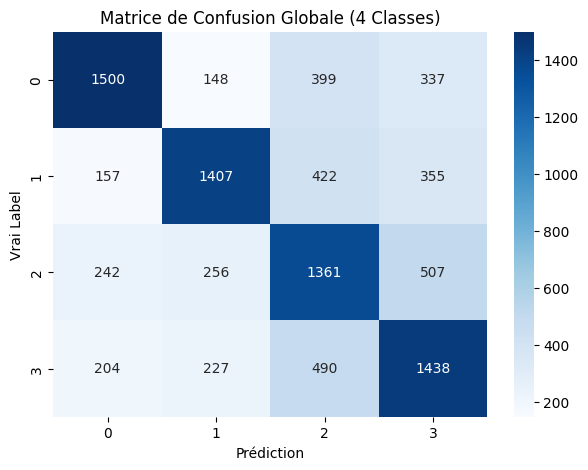


Rapport de Classification Global :
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      2384
           1       0.69      0.60      0.64      2341
           2       0.51      0.58      0.54      2366
           3       0.55      0.61      0.58      2359

    accuracy                           0.60      9450
   macro avg       0.61      0.60      0.61      9450
weighted avg       0.61      0.60      0.61      9450



In [7]:
acc_glob_4 = run_global_phase(X4, y4, g4, n_classes=4)


In [4]:
def run_transfer_phase(X, y, groups, n_classes):
    print(f"\n" + "="*60 + f"\nPHASE 2 : TRANSFER LEARNING INDIVIDUEL ({n_classes} CLASSES)\n" + "="*60)
    
    unique_subs = np.unique(groups)
    all_subs_pre, all_subs_post = [], []
    weights_path = f'eegnet_global_ref_{n_classes}cl.weights.h5'

    for i, sub_id in enumerate(unique_subs):
        # 1. Libération de la mémoire RAM/GPU au début de chaque sujet
        tf.keras.backend.clear_session()
        
        idx = np.where(groups == sub_id)[0]
        X_sub, y_sub = X[idx], y[idx]
        
        # 2. Construction du modèle UNE SEULE FOIS par sujet
        model_tl = build_eegnet(n_classes=n_classes)
        model_tl.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
                         loss='categorical_crossentropy', metrics=['accuracy'])
        
        kf_sub = KFold(n_splits=4, shuffle=True, random_state=42)
        sub_folds_pre, sub_folds_post = [], []
        
        for t_idx, v_idx in kf_sub.split(X_sub):
            # 3. Réinitialisation aux poids globaux (évite de reconstruire l'objet)
            model_tl.load_weights(weights_path)
            
            # Évaluation Baseline (Avant adaptation) 
            _, acc_pre = model_tl.evaluate(X_sub[v_idx], y_sub[v_idx], verbose=0)
            sub_folds_pre.append(acc_pre)
            
            # Fine-tuning court : 5 époques 
            model_tl.fit(X_sub[t_idx], y_sub[t_idx], epochs=5, batch_size=16, verbose=1)
            
            # Évaluation Finale (Après adaptation) 
            _, acc_post = model_tl.evaluate(X_sub[v_idx], y_sub[v_idx], verbose=0)
            sub_folds_post.append(acc_post)
            
        all_subs_pre.append(np.mean(sub_folds_pre))
        all_subs_post.append(np.mean(sub_folds_post))
        
        # Affichage du progrès tous les 10 sujets
        if (i+1) % 10 == 0:
            current_avg = np.mean(all_subs_post)
            print(f"Progrès : {i+1}/{len(unique_subs)} sujets | Accuracy moyenne : {current_avg:.2%}")

    # Visualisation des résultats
    gains = (np.array(all_subs_post) - np.array(all_subs_pre)) * 100
    print(f"\nRESULTAT FINAL SS-TL ({n_classes} cl) : {np.mean(all_subs_post):.2%}")
    print(f"Gain moyen : {np.mean(gains):+.2f}%")
    
    return np.mean(all_subs_post)




In [11]:
acc_tl_4 = run_transfer_phase(X4, y4, g4, n_classes=4)


PHASE 2 : TRANSFER LEARNING INDIVIDUEL (4 CLASSES)


I0000 00:00:1767984700.473926      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767984700.477908      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1767984703.071403     139 service.cc:152] XLA service 0x7e61000672a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767984703.071443     139 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7165 - loss: 0.8236
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7282 - loss: 0.8699
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7626 - loss: 0.6906
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6954 - loss: 0.7862
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6501 - loss: 0.7646
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7110 - loss: 0.8076
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7082 - loss: 0.8126
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7314 - loss: 0.7613
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7574 - loss: 0.8129
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6971 - loss: 0.7771
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7798 - loss: 0.7370 
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7387 - loss: 0.7625
Epoch 3/5
5/5 ━━━━

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.constraints import MaxNorm

def build_model_optimized(n_channels=64, n_times=480, n_classes=4):
    
    F1 = 8
    D = 2 
    F2 = 16 
    kernel_length = 128  
    pool1 = 8            
    pool2 = 8            
    dropout_rate = 0.5   

    input_layer = Input(shape=(n_channels, n_times, 1))

    # --- BLOC 1 : Convolution Temporelle ---
    # Apprend les filtres fréquentiels 
    block1 = Conv2D(F1, (1, kernel_length), padding='same', use_bias=False)(input_layer)
    block1 = BatchNormalization()(block1)

    # --- BLOC 2 : Convolution Spatiale (Depthwise) ---
    # Apprend les filtres spatiaux pour chaque filtre temporel
    block2 = DepthwiseConv2D((n_channels, 1), depth_multiplier=D, 
                             depthwise_constraint=MaxNorm(1.), 
                             use_bias=False, padding='valid')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    
    # Pooling agressif (8) pour réduire la taille et le bruit
    block2 = AveragePooling2D((1, pool1))(block2) 
    block2 = Dropout(dropout_rate)(block2)

    # --- BLOC 3 : Convolution Séparable ---
    # Combine les infos temporelles et spatiales de manière compacte
    block3 = SeparableConv2D(F2, (1, 16), padding='same', use_bias=False)(block2)
    block3 = BatchNormalization()(block3)
    block3 = Activation('elu')(block3)
    
    block3 = AveragePooling2D((1, pool2))(block3)
    block3 = Dropout(dropout_rate)(block3)

    # --- CLASSIFICATION ---
    flatten = Flatten()(block3)
    output = Dense(n_classes, activation='softmax', 
                   kernel_constraint=MaxNorm(0.25))(flatten)

    return Model(inputs=input_layer, outputs=output)

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf


def lr_scheduler_wang(epoch):
    if epoch < 20:
        return 0.01
    elif epoch < 50:
        return 0.001
    else:
        return 0.0001

def run_global_phase_optimized(X, y, groups, n_classes):
    print(f"\n" + "="*60 + f"\nPHASE 1 : VALIDATION GLOBALE ({n_classes} CLASSES)\n" + "="*60)
    
    # Validation Croisée 5-Folds 
    gkf = GroupKFold(n_splits=5)
    fold_results = []
    
 
    lr_callback = LearningRateScheduler(lr_scheduler_wang)
    
   
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
        print(f"\n>>> FOLD {fold+1}/5")
        
       
        model = build_model_optimized(n_channels=64, n_times=480, n_classes=n_classes)
        
        model.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        
        # Entraînement
        history = model.fit(X[train_idx], y[train_idx], 
                            epochs=100,  # Max epochs 
                            batch_size=16, # Batch size 
                            validation_data=(X[val_idx], y[val_idx]), 
                            callbacks=[lr_callback, early_stop], 
                            verbose=1)
        
        _, acc = model.evaluate(X[val_idx], y[val_idx], verbose=0)
        fold_results.append(acc)
        print(f"--> Accuracy Fold {fold+1}: {acc:.2%}")
        
        # Sauvegarde du modèle du premier fold pour le Transfer Learning
        if fold == 0:
            model.save_weights(f'eegnet_global_ref_{n_classes}cl.weights.h5')
            
            # Graphe de convergence (pour vérifier que le LR scheduler fonctionne)
            plt.figure(figsize=(8, 4))
            plt.plot(history.history['accuracy'], label='Train Acc')
            plt.plot(history.history['val_accuracy'], label='Val Acc')
            plt.axvline(x=20, color='r', linestyle='--', alpha=0.5, label='LR Drop 1')
            plt.axvline(x=50, color='r', linestyle='--', alpha=0.5, label='LR Drop 2')
            plt.title(f'Convergence Fold 1 ({n_classes} Classes)')
            plt.legend()
            plt.show()

    avg_acc = np.mean(fold_results)
    print(f"\nRESULTAT GLOBAL MOYEN ({n_classes} cl) : {avg_acc:.2%}")
    return avg_acc

>>> CHARGEMENT DONNÉES 2 CLASSES (G/D)...

PHASE 1 : VALIDATION GLOBALE (2 CLASSES)

>>> FOLD 1/5


I0000 00:00:1768054569.259150      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/100


I0000 00:00:1768054574.529385     126 service.cc:152] XLA service 0x7b0a850118d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768054574.529427     126 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768054574.972509     126 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768054579.745362     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/237 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.7447 - loss: 0.5272 - val_accuracy: 0.8042 - val_loss: 0.4184 - learning_rate: 0.0100
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7945 - loss: 0.4413 - val_accuracy: 0.8021 - val_loss: 0.4270 - learning_rate: 0.0100
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8101 - loss: 0.4152 - val_accuracy: 0.8169 - val_loss: 0.4181 - learning_rate: 0.0100
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7910 - loss: 0.4405 - val_accuracy: 0.8074 - val_loss: 0.4157 - learning_rate: 0.0100
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8044 - loss: 0.4275 - val_accuracy: 0.7862 - val_loss: 0.4406 - learning_rate: 0.0100
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7966 - loss: 0.4262 - val_accuracy: 0.8116 - val_loss: 0.4272 - learning_rate: 0.0100
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7965 - loss: 0.4362

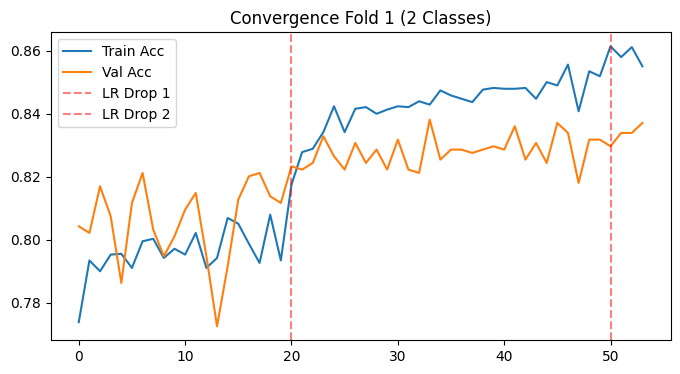


>>> FOLD 2/5
Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.7216 - loss: 0.5292 - val_accuracy: 0.7799 - val_loss: 0.4746 - learning_rate: 0.0100
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8030 - loss: 0.4376 - val_accuracy: 0.8032 - val_loss: 0.4446 - learning_rate: 0.0100
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7959 - loss: 0.4342 - val_accuracy: 0.8201 - val_loss: 0.4187 - learning_rate: 0.0100
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8052 - loss: 0.4174 - val_accuracy: 0.8169 - val_loss: 0.4162 - learning_rate: 0.0100
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8069 - loss: 0.4197 - val_accuracy: 0.7905 - val_loss: 0.4565 - learning_rate: 0.0100
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8035 - loss: 0.4331 - val_accuracy: 0.8085 - val_loss: 0.4347 - learning_rate: 0.0100
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accur

In [8]:
# --- EXPÉRIENCE 1 : 2 CLASSES ---
print(">>> CHARGEMENT DONNÉES 2 CLASSES (G/D)...")
acc_2 = run_global_phase_optimized(X2, y2, g2, n_classes=2)



print("\n" + "="*40)
print("BILAN FINAL VALIDATION GLOBALE")
print("="*40)
print(f"2 Classes  : {acc_2:.2%}")



>>> CHARGEMENT DONNÉES 4 CLASSES (Repos/G/D/Pieds)...

PHASE 1 : VALIDATION GLOBALE (4 CLASSES)

>>> FOLD 1/5


I0000 00:00:1768003793.147613      54 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768003793.151413      54 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/100


I0000 00:00:1768003799.488929     131 service.cc:152] XLA service 0x7e1a90005e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768003799.488986     131 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768003799.488992     131 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768003799.893900     131 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768003804.857966     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


460/460 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.4165 - loss: 1.2587 - val_accuracy: 0.5057 - val_loss: 1.1326 - learning_rate: 0.0100
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4853 - loss: 1.1789 - val_accuracy: 0.5008 - val_loss: 1.1468 - learning_rate: 0.0100
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5124 - loss: 1.1421 - val_accuracy: 0.5226 - val_loss: 1.1415 - learning_rate: 0.0100
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5256 - loss: 1.1410 - val_accuracy: 0.5455 - val_loss: 1.0889 - learning_rate: 0.0100
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5080 - loss: 1.1406 - val_accuracy: 0.5264 - val_loss: 1.1349 - learning_rate: 0.0100
Epoch 6/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5122 - loss: 1.1500 - val_accuracy: 0.5057 - val_loss: 1.1639 - learning_rate: 0.0100
Epoch 7/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5185 - loss: 1.1371 - val

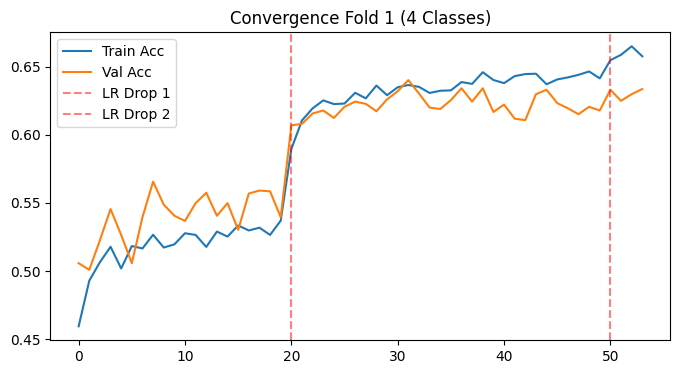


>>> FOLD 2/5
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.4294 - loss: 1.2659 - val_accuracy: 0.5318 - val_loss: 1.1171 - learning_rate: 0.0100
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4749 - loss: 1.1869 - val_accuracy: 0.5602 - val_loss: 1.0755 - learning_rate: 0.0100
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4891 - loss: 1.1815 - val_accuracy: 0.5367 - val_loss: 1.0996 - learning_rate: 0.0100
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4965 - loss: 1.1630 - val_accuracy: 0.5509 - val_loss: 1.1152 - learning_rate: 0.0100
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4993 - loss: 1.1661 - val_accuracy: 0.5318 - val_loss: 1.1183 - learning_rate: 0.0100
Epoch 6/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5069 - loss: 1.1383 - val_accuracy: 0.5727 - val_loss: 1.0497 - learning_rate: 0.0100
Epoch 7/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0

In [8]:

print("\n>>> CHARGEMENT DONNÉES 4 CLASSES (Repos/G/D/Pieds)...")

acc_4 = run_global_phase_optimized(X4, y4, g4, n_classes=4)

print("\n" + "="*40)
print("BILAN FINAL VALIDATION GLOBALE")
print("="*40)
print(f"4 Classes  : {acc_4:.2%}")

In [10]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import gc  

def run_ss_tl_phase(X, y, groups, n_classes, global_weights_path):
    print(f"\n" + "="*60 + f"\nPHASE 2 : TRANSFER LEARNING (MODE RAPIDE) - {n_classes} CLASSES\n" + "="*60)
    
    unique_subs = np.unique(groups)
    all_subs_acc = []
    all_subs_baseline = []

    print(f"Démarrage sur {len(unique_subs)} sujets...")
       
    for i, sub_id in enumerate(unique_subs):
        idx = np.where(groups == sub_id)[0]
        X_sub, y_sub = X[idx], y[idx]
      
        kf_sub = KFold(n_splits=2, shuffle=True, random_state=42)
        
        sub_folds_acc = []
        sub_folds_base = []
        
        for t_idx, v_idx in kf_sub.split(X_sub):
            # Nettoyage mémoire
            tf.keras.backend.clear_session()
            gc.collect() 
            
            # 1. Construction
            model_tl = build_eegnet_optimized(n_channels=64, n_times=480, n_classes=n_classes)
            model_tl.load_weights(global_weights_path)
            
            # LR un peu plus élevé (0.0002) pour compenser la réduction d'époques
            model_tl.compile(optimizer=tf.keras.optimizers.Adam(0.0005), 
                             loss='categorical_crossentropy', metrics=['accuracy'])
            
            # 2. Baseline
            _, base_acc = model_tl.evaluate(X_sub[v_idx], y_sub[v_idx], verbose=0)
            sub_folds_base.append(base_acc)
            
      
            model_tl.fit(X_sub[t_idx], y_sub[t_idx], 
                         epochs=5,    
                         batch_size=16, 
                         verbose=0)
            
            # 4. Évaluation
            _, acc = model_tl.evaluate(X_sub[v_idx], y_sub[v_idx], verbose=0)
            sub_folds_acc.append(acc)
            
            # Suppression immédiate
            del model_tl 
        
        # Moyennes
        avg_acc = np.mean(sub_folds_acc)
        all_subs_acc.append(avg_acc)
        all_subs_baseline.append(np.mean(sub_folds_base))
        
        print(f"Sujet {i+1}/{len(unique_subs)} | Acc: {avg_acc:.2%}")

    # --- RÉSULTATS ---
    final_acc = np.mean(all_subs_acc)
    gain = final_acc - np.mean(all_subs_baseline)
    
    print("\n" + "-"*40)
    print(f"RÉSULTAT FINAL  : {final_acc:.2%} (Gain: {gain:+.2%})")
    
    return final_acc
   

In [7]:
weights_file = 'eegnet_global_ref_4cl.weights.h5' 
acc_tl_4 = run_ss_tl_phase(X4, y4, g4, n_classes=4, global_weights_path=weights_file)


PHASE 2 : TRANSFER LEARNING (MODE RAPIDE) - 4 CLASSES
Démarrage sur 105 sujets...


I0000 00:00:1768051064.635770      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1768051066.592369     131 service.cc:152] XLA service 0x7b2058069dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768051066.592400     131 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768051066.725902     131 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768051068.876819     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Sujet 1/105 | Acc: 76.49%
Sujet 2/105 | Acc: 79.07%
Sujet 3/105 | Acc: 86.52%
Sujet 4/105 | Acc: 80.68%
Sujet 5/105 | Acc: 53.94%
Sujet 6/105 | Acc: 86.36%
Sujet 7/105 | Acc: 93.18%
Sujet 8/105 | Acc: 67.89%
Sujet 9/105 | Acc: 89.64%
Sujet 10/105 | Acc: 60.91%
Sujet 11/105 | Acc: 53.41%
Sujet 12/105 | Acc: 62.50%
Sujet 13/105 | Acc: 73.86%
Sujet 14/105 | Acc: 76.74%
Sujet 15/105 | Acc: 90.91%
Sujet 16/105 | Acc: 52.33%
Sujet 17/105 | Acc: 61.63%
Sujet 18/105 | Acc: 92.05%
Sujet 19/105 | Acc: 69.32%
Sujet 20/105 | Acc: 71.19%
Sujet 21/105 | Acc: 65.12%
Sujet 22/105 | Acc: 92.12%
Sujet 23/105 | Acc: 51.66%
Sujet 24/105 | Acc: 71.59%
Sujet 25/105 | Acc: 55.81%
Sujet 26/105 | Acc: 53.86%
Sujet 27/105 | Acc: 75.00%
Sujet 28/105 | Acc: 59.70%
Sujet 29/105 | Acc: 54.55%
Sujet 30/105 | Acc: 74.42%
Sujet 31/105 | Acc: 69.03%
Sujet 32/105 | Acc: 82.95%
Sujet 33/105 | Acc: 68.18%
Sujet 34/105 | Acc: 73.86%
Sujet 35/105 | Acc: 69.77%
Sujet 36/105 | Acc: 78.41%
Sujet 37/105 | Acc: 81.82%
Sujet 38/1

In [11]:
weights_file = 'eegnet_global_ref_2cl.weights.h5' 
acc_tl_4 = run_ss_tl_phase(X2, y2, g2, n_classes=2, global_weights_path=weights_file)


PHASE 2 : TRANSFER LEARNING (MODE RAPIDE) - 2 CLASSES
Démarrage sur 105 sujets...
Sujet 1/105 | Acc: 97.83%
Sujet 2/105 | Acc: 93.38%
Sujet 3/105 | Acc: 95.65%
Sujet 4/105 | Acc: 93.28%
Sujet 5/105 | Acc: 62.15%
Sujet 6/105 | Acc: 95.65%
Sujet 7/105 | Acc: 97.73%
Sujet 8/105 | Acc: 88.83%
Sujet 9/105 | Acc: 95.55%
Sujet 10/105 | Acc: 71.25%
Sujet 11/105 | Acc: 86.76%
Sujet 12/105 | Acc: 95.55%
Sujet 13/105 | Acc: 73.42%
Sujet 14/105 | Acc: 68.87%
Sujet 15/105 | Acc: 100.00%
Sujet 16/105 | Acc: 73.52%
Sujet 17/105 | Acc: 95.55%
Sujet 18/105 | Acc: 100.00%
Sujet 19/105 | Acc: 86.66%
Sujet 20/105 | Acc: 95.55%
Sujet 21/105 | Acc: 80.14%
Sujet 22/105 | Acc: 100.00%
Sujet 23/105 | Acc: 82.31%
Sujet 24/105 | Acc: 77.87%
Sujet 25/105 | Acc: 55.63%
Sujet 26/105 | Acc: 64.33%
Sujet 27/105 | Acc: 84.39%
Sujet 28/105 | Acc: 84.68%
Sujet 29/105 | Acc: 82.21%
Sujet 30/105 | Acc: 86.66%
Sujet 31/105 | Acc: 93.48%
Sujet 32/105 | Acc: 95.55%
Sujet 33/105 | Acc: 93.28%
Sujet 34/105 | Acc: 82.11%
Sujet